# Imports

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
import numpy as np
from matplotlib import pyplot as plt
import camb
from camb import model, initialpower
import bayesflow as bf

import seaborn as sns

print('Using CAMB %s installed at %s' % (camb.__version__, os.path.dirname(camb.__file__)))
# make sure the version and path is what you expect

# Data generating process

## Definitions

def prior(batch_size, seed=None):
    
    rng = np.random.default_rng(seed)

    H0 = rng.uniform(50, 90, size=batch_size)
    Omega_m = rng.uniform(0.2, 0.4, size=batch_size)
    n_s = rng.uniform(0.9, 1.0, size=batch_size)

    return dict(H0 = H0,
                Omega_m = Omega_m,
                n_s = n_s)

In [143]:
def generate_PK(H0, Omega_m, n_s, k_vals=None, noise_level=0.2, seed=None):
    """
    Generate noisy matter power spectrum P(k) from given cosmological parameters.

    Parameters:
        H0 (float): Hubble constant (km/s/Mpc)
        Omega_m (float): total matter density (Ω_m)
        n_s (float): spectral index
        k_vals (np.array or None): k values (1/Mpc). Default: logspace from 1e-3 to ~3.16
        noise_level (float): relative Gaussian noise (e.g., 0.05 = 5%)

    Returns:
        noisy_P_k (np.array): noisy matter power spectrum at redshift z=0
    """
    # Default k range: safe values for CAMB
    if k_vals is None:
        k_vals = np.logspace(-4, 0.5, 1024)


    ## To calculate the physical densities from the densities 
    # Baryon density
    Omega_b = 0.05
    
    # Cold dark matter density
    Omega_c = Omega_m - Omega_b

    # dimensionless Hubble parameter
    h = H0 / 100

    
    # physical densities
    ombh2 = Omega_b * h**2
    omch2 = Omega_c * h**2


    # Setup CAMB
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2)
    pars.InitPower.set_params(ns=n_s)
    pars.set_matter_power(redshifts=[0], kmax=max(k_vals))

    # Run CAMB and get P(k)
    PK = camb.get_matter_power_interpolator(pars, nonlinear=False, kmax=max(k_vals))
    P_k = PK.P(0, k_vals)

     # Conditional RNG
    if seed is not None:
        rng = np.random.default_rng(seed)  # reproducible
    else:
        rng = np.random.default_rng()      # fresh random

    # Add heteroscedastic Gaussian noise.
    # Noise is added according to the scale of P_k which make more realistic observations
    noise = rng.normal(0, noise_level * P_k)
    P_k_noisy = P_k + noise

    return {
        'k': k_vals,
        'P_k_noisy': P_k_noisy,
        'P_k_clean': P_k  # optional, useful for comparison
    }

## Generating noisy observations

$\theta^*$, True parameter from Planck 2018

In [144]:
# Define the true cosmological parameters
theta_star = {
    'H0': 67.4,
    'Omega_m': 0.315,
    'n_s': 0.965
}

In [178]:
# Generate the noisy power spectrum using theta_star
Pk_obs = generate_PK(
    H0=theta_star['H0'],
    Omega_m=theta_star['Omega_m'],
    n_s=theta_star['n_s'],
    noise_level=0.2,   # 20% relative Gaussian noise
    seed=42            # Optional, for reproducibility
)

In [179]:
print(len(Pk_test))

1


In [180]:
print(Pk_test['P_k_noisy'].shape)

(1024,)


## Visualization

P(k) vs k_vals

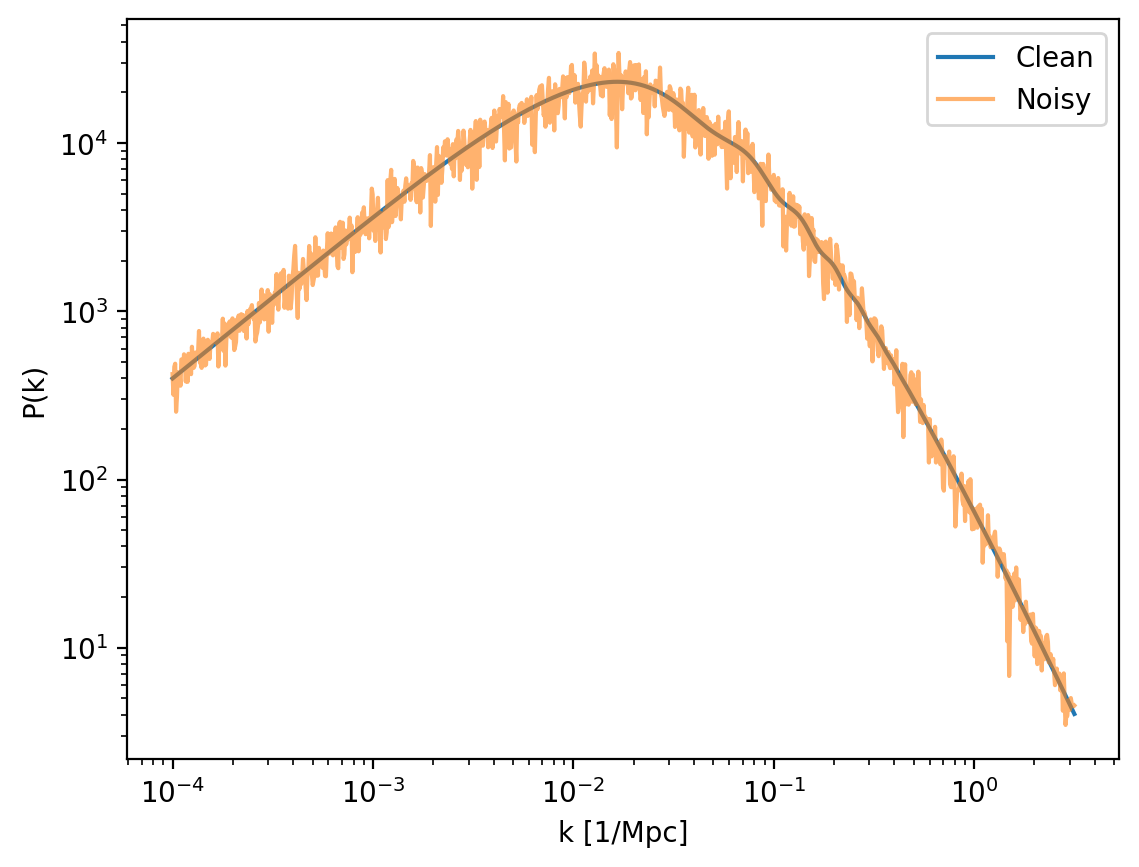

In [181]:
## Ploting the P_obs vs k_vals
plt.loglog(Pk_obs['k'], Pk_obs['P_k_clean'], label='Clean')
plt.loglog(Pk_obs['k'], Pk_obs['P_k_noisy'], label='Noisy', alpha=0.6)
plt.xlabel('k [1/Mpc]')
plt.ylabel('P(k)')
plt.legend()
plt.show()

$f(P\_k))$, probability density of power spectrum

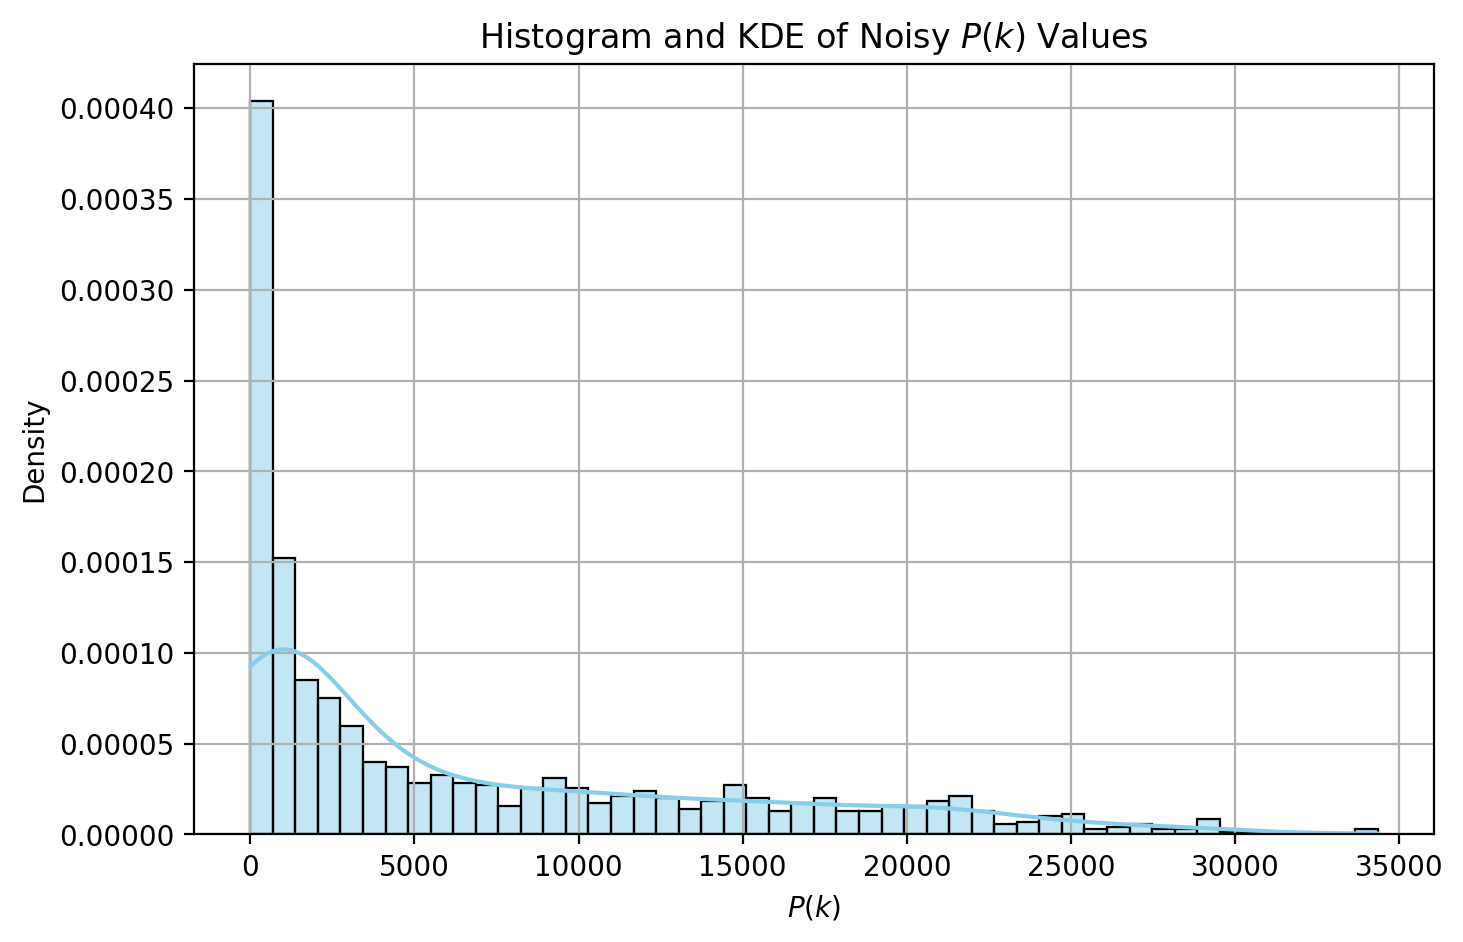

In [182]:
# Extract the noisy P(k) values
P_k_noisy = Pk_obs['P_k_noisy']

# Plot histogram and KDE
plt.figure(figsize=(8, 5))
sns.histplot(P_k_noisy, bins=50, kde=True, stat="density", color='skyblue', edgecolor='black')

plt.title('Histogram and KDE of Noisy $P(k)$ Values')
plt.xlabel('$P(k)$')
plt.ylabel('Density')
plt.grid(True)
plt.show()


## Definitions part 2

Sample from prior: $(\theta^{(s)}) \sim P(\theta)$

In [183]:
def prior(seed=None):
    rng = np.random.default_rng(seed)

    H0 = rng.uniform(50, 90)
    Omega_m = rng.uniform(0.2, 0.4)
    n_s = rng.uniform(0.9, 1.0)

    return {
        'H0': H0,
        'Omega_m': Omega_m,
        'n_s': n_s
    }


In [184]:
prior()

{'H0': 82.6154002038756,
 'Omega_m': 0.3250407826976095,
 'n_s': 0.9618596439341288}

Sample from the Likelihood: $(y^{(s)}) \sim P(y | \theta)$
The same function but with just one output of length of k_vals

In [232]:
def likelihood(H0, Omega_m, n_s, k_vals=None, noise_level=0.2, seed=None):
    """
        Same function as generate_PK(), the only difference is the single output "P_K_noisy".
        Redefining, just make it Likelihood.
        Also, note that n = len(k_vals) = 128
    """
    # Default k range: safe values for CAMB
    if k_vals is None:
        k_vals = np.logspace(-4, 0.5, 128) 


    ## To calculate the physical densities from the densities 
    
    # Baryon density (Well Know Constant from Plank 2018)
    Omega_b = 0.05
    
    # Cold dark matter density
    Omega_c = Omega_m - Omega_b

    # dimensionless Hubble parameter
    h = H0 / 100

    
    # physical densities
    ombh2 = Omega_b * h**2
    omch2 = Omega_c * h**2


    # Setup CAMB
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2)
    pars.InitPower.set_params(ns=n_s)
    pars.set_matter_power(redshifts=[0], kmax=max(k_vals))

    # Run CAMB and get P(k)
    PK = camb.get_matter_power_interpolator(pars, nonlinear=False, kmax=max(k_vals))
    P_k = PK.P(0, k_vals)

     # Conditional RNG
    if seed is not None:
        rng = np.random.default_rng(seed)  # reproducible
    else:
        rng = np.random.default_rng()      # fresh random

    # Add heteroscedastic Gaussian noise.
    # Noise is added according to the scale of P_k which make more realistic observations
    noise = rng.normal(0, noise_level * P_k)
    P_k_noisy = P_k + noise
    P_k_noisy = P_k_noisy.reshape(-1, 1)

    return {'P_k_noisy': P_k_noisy}

### Testing Prior and Likelihood

In [233]:
theta_test = prior()
print(theta_test)

{'H0': 81.35507852271965, 'Omega_m': 0.3038759858867524, 'n_s': 0.9521499525679155}


In [234]:
# Generate the noisy power spectrum using theta_star
Pk_test = likelihood(
    H0=theta_test['H0'],
    Omega_m=theta_test['Omega_m'],
    n_s=theta_test['n_s'],
    noise_level=0.2   # 20% relative Gaussian noise
)

In [235]:
Pk_test['P_k_noisy'].shape


(128, 1)

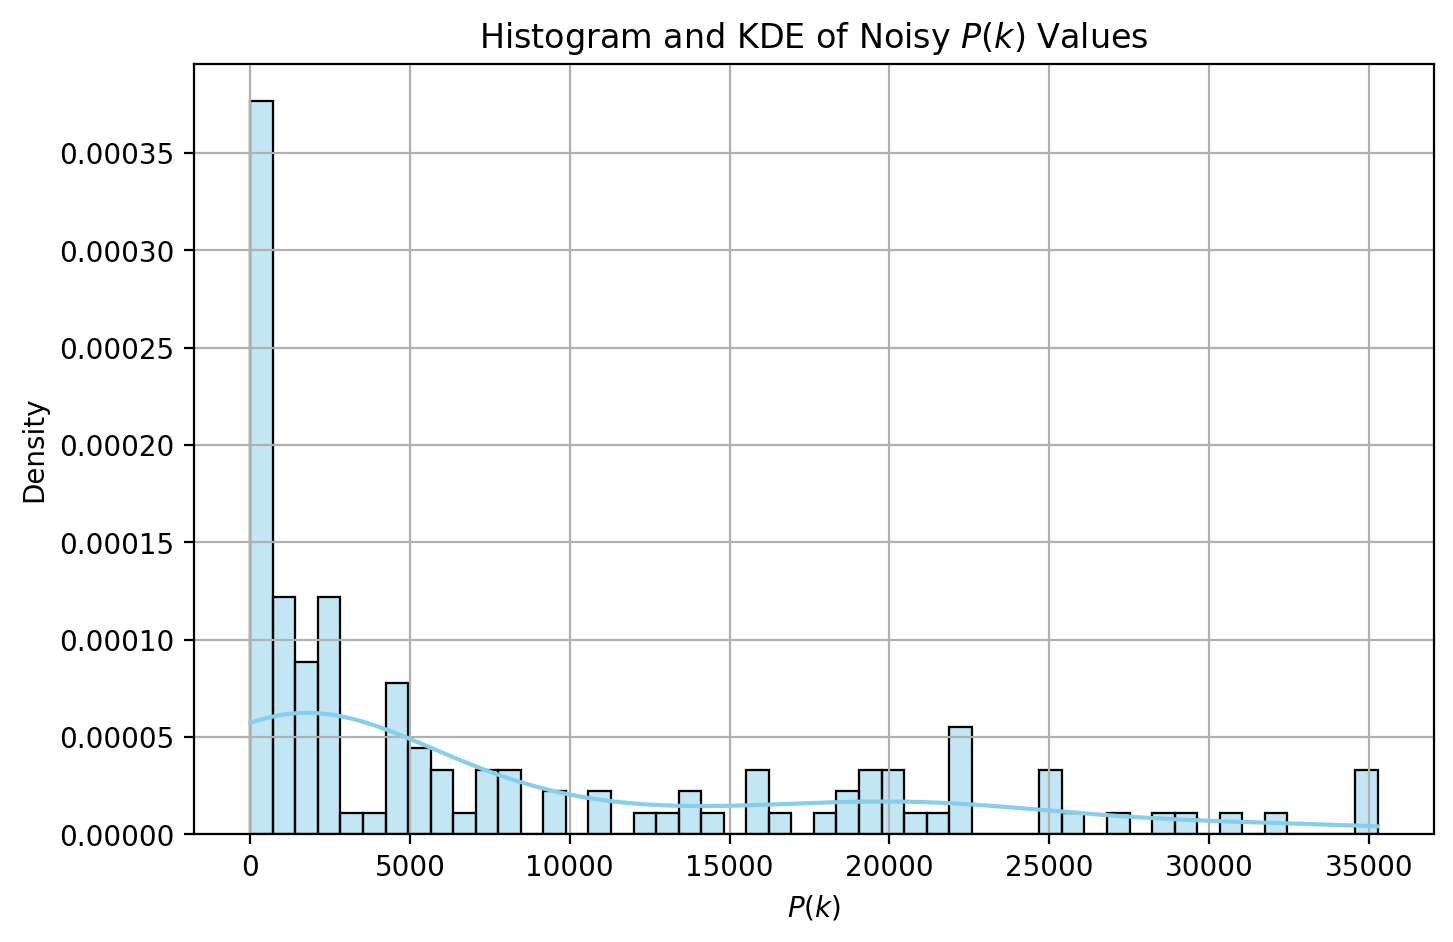

In [236]:
# Plot histogram and KDE
plt.figure(figsize=(8, 5))
sns.histplot(Pk_test['P_k_noisy'].flatten(), bins=50, kde=True, stat="density", color='skyblue', edgecolor='black')

plt.title('Histogram and KDE of Noisy $P(k)$ Values')
plt.xlabel('$P(k)$')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Bayes Flow Workflow

## Sample from the Joint Distribution $(\theta^{(s)}, y^{(s)}) \sim P(\theta, y)$

### Simulator

In [238]:
simulator = bf.make_simulator([prior, likelihood])

In [239]:
# simulator.sample(2)

###  Adapter 

In [240]:
adapter = (
    bf.Adapter()
    .concatenate(["H0", "Omega_m", "n_s"], into="inference_variables")
    .rename("P_k_noisy", "summary_variables")
)


In [241]:
# adapter(dataset)

### Summary Network

In [242]:
summary_network = bf.networks.DeepSet()

# 1) Affine Coupling Model

### Affine Inference Network

In [243]:
inference_network = bf.networks.CouplingFlow() 

### Affine Workflow

In [244]:
workflow = bf.BasicWorkflow(
     inference_network=inference_network,
     summary_network=summary_network,
     adapter=adapter,
     simulator=simulator
)

### Simulating S = 10,000 datasets

In [248]:
training_data = workflow.simulate(10000)
validation_data = workflow.simulate(1000)

In [246]:
# history = workflow.fit_online(epochs=3, num_batches_per_epoch= 5, batch_size=64, validation_data=10)

In [249]:
training_data['P_k_noisy']

(10000, 128, 1)

Plotting any random simulated dataset just to know whether the simulator working properly

In [303]:
all_pks = training_data['P_k_noisy'][np.random.randint(1, 1000)] 

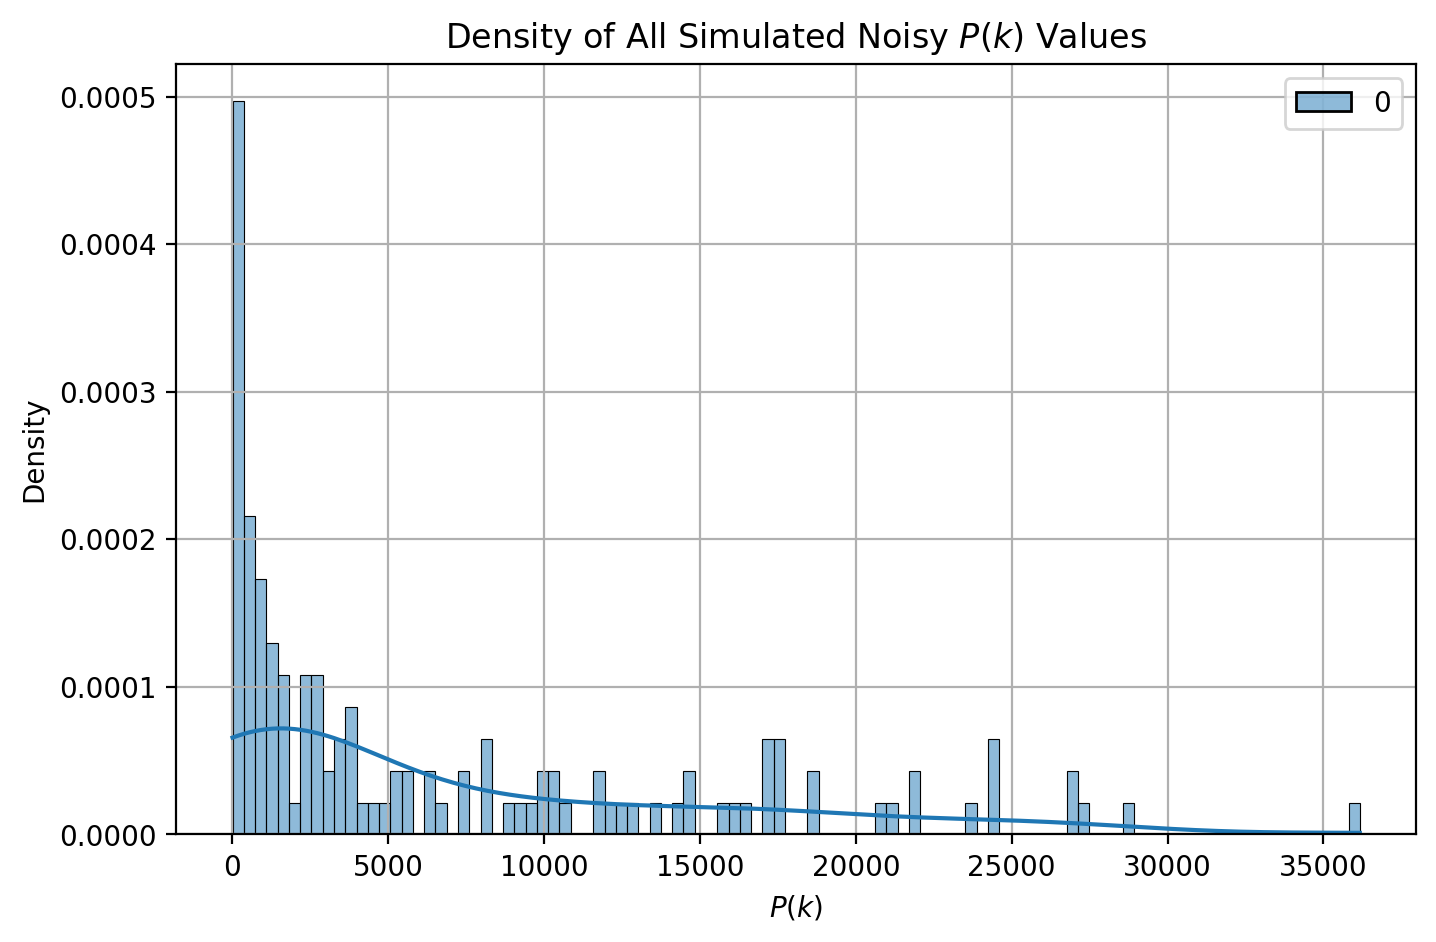

In [304]:
plt.figure(figsize=(8, 5))
sns.histplot(all_pks, bins=100, kde=True, stat='density', color='skyblue', edgecolor='black')

plt.title('Density of All Simulated Noisy $P(k)$ Values')
plt.xlabel('$P(k)$')
plt.ylabel('Density')
plt.grid(True)
plt.show()


This means the simulator is correct.

In [250]:
history = workflow.fit_offline(
    data = training_data,
    epochs=100,
    num_batches_per_epoch=200,
    batch_size=128,
    validation_data = validation_data
)


INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 41s 250ms/step - loss: 4.2592 - val_loss: 4.2337
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 18s 233ms/step - loss: 4.2586 - val_loss: 4.2350
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 214ms/step - loss: 4.2638 - val_loss: 4.2352
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 217ms/step - loss: 4.2605 - val_loss: 4.2349
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 18s 223ms/step - loss: 4.2591 - val_loss: 4.2367
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 233ms/step - loss: 4.2561 - val_loss: 4.2351
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 18s 227ms/step - loss: 4.2596 - val_loss: 4.2347
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 235ms/step - loss: 4.2598 - val_loss: 4.2336
Epoch 9/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 18s 222ms/step - loss: 4.2587 - val_loss: 4.2335
Epoch 10/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 18s 222ms/step - loss: 4.2595 - val_loss: 4.2324
Epoch 11/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 20s 249ms/step - loss: 4.2582 - val_loss: 4.2330
Epoch 12/100
79/79 ━━━━━━━━━━━

In [ ]:
history = workflow.fit_offline(
    data=training_data, 
    epochs=10, 
    batch_size=64, 
    validation_data = validation_data
)

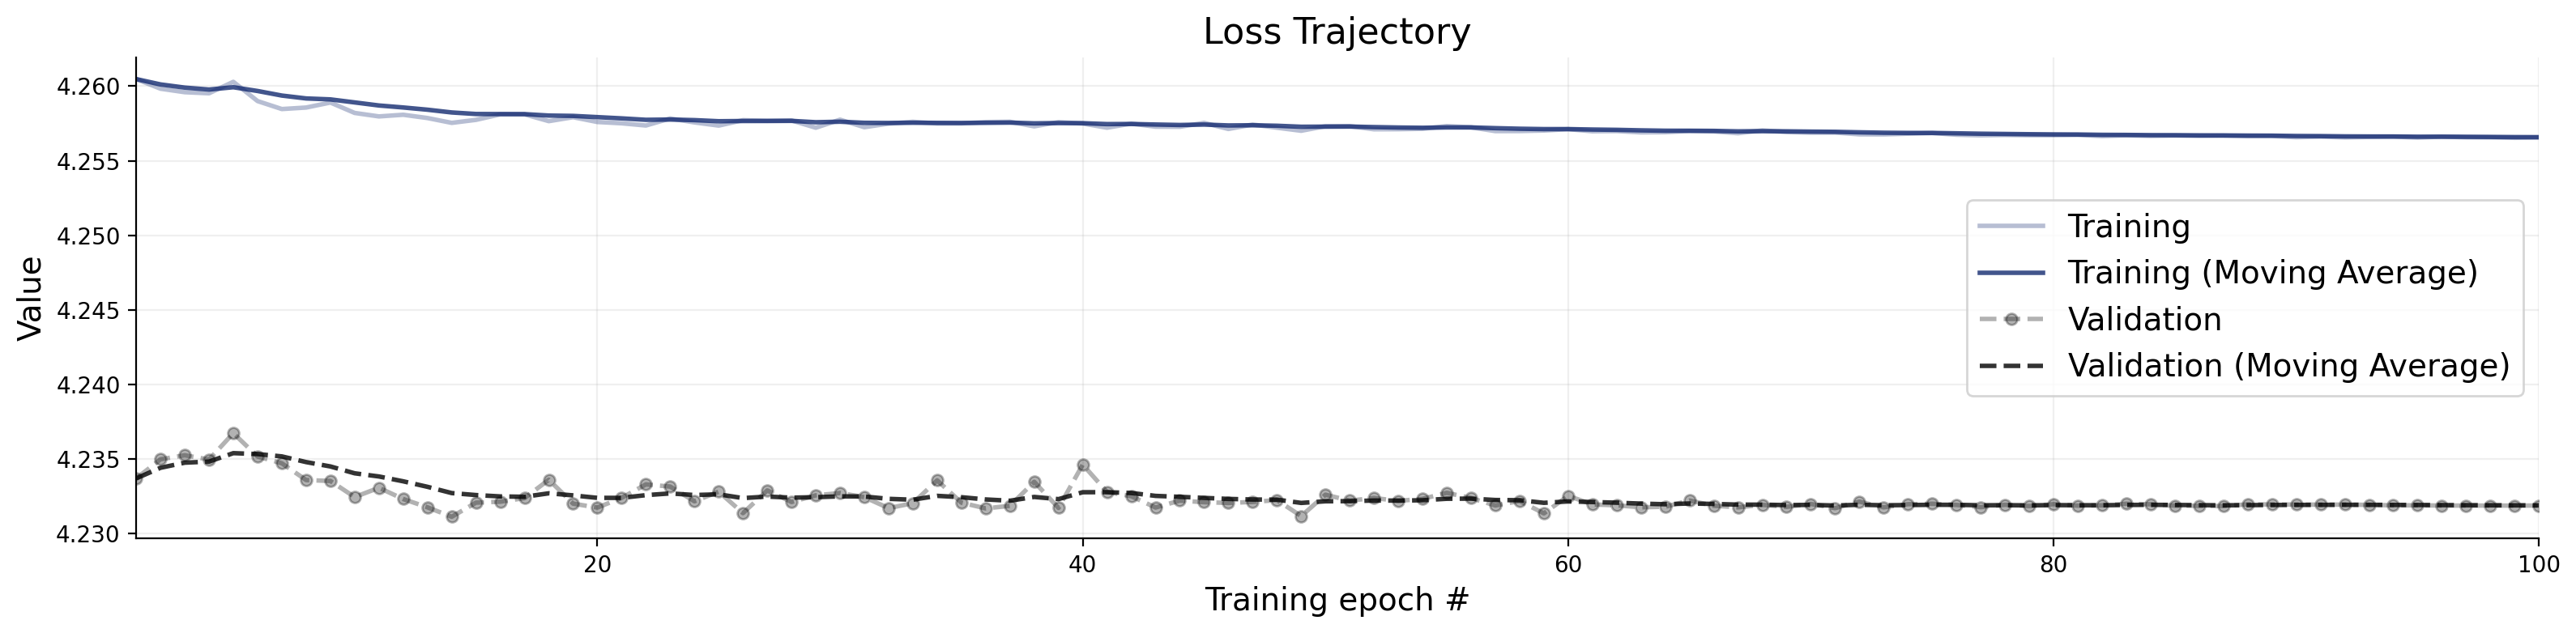

In [251]:
f = bf.diagnostics.plots.loss(history)

# Test Data

In [252]:
# Set the number of posterior draws you want to get
num_datasets = 300
num_samples = 1000

# Simulate 300 scenarios
test_data = workflow.simulate(num_datasets)



### Sample posterior from the trained affine inference network
Sample 1000 posterior samples from each simulated dataset of 300

In [ ]:
samples = workflow.sample(conditions=test_data, num_samples=num_samples)

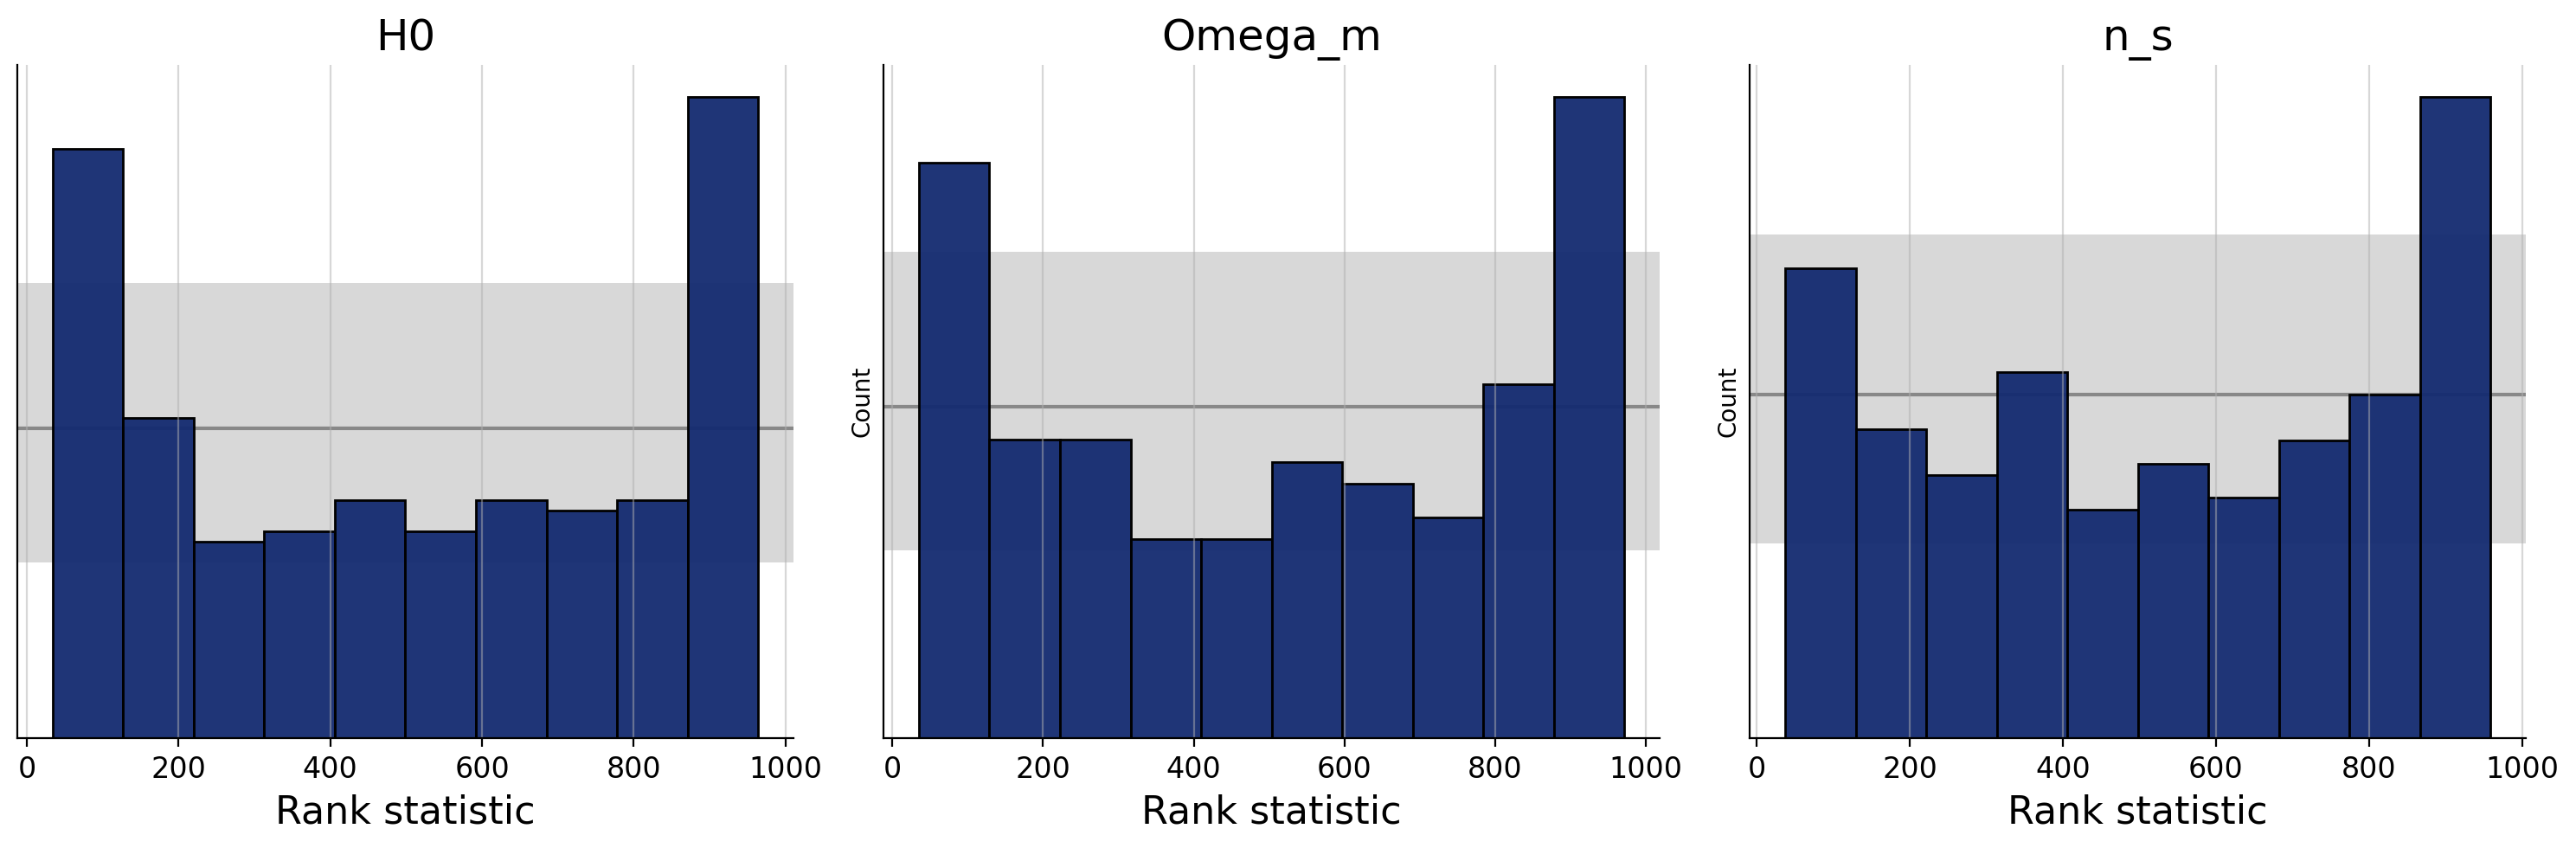

In [260]:
f = bf.diagnostics.plots.calibration_histogram(samples, test_data)

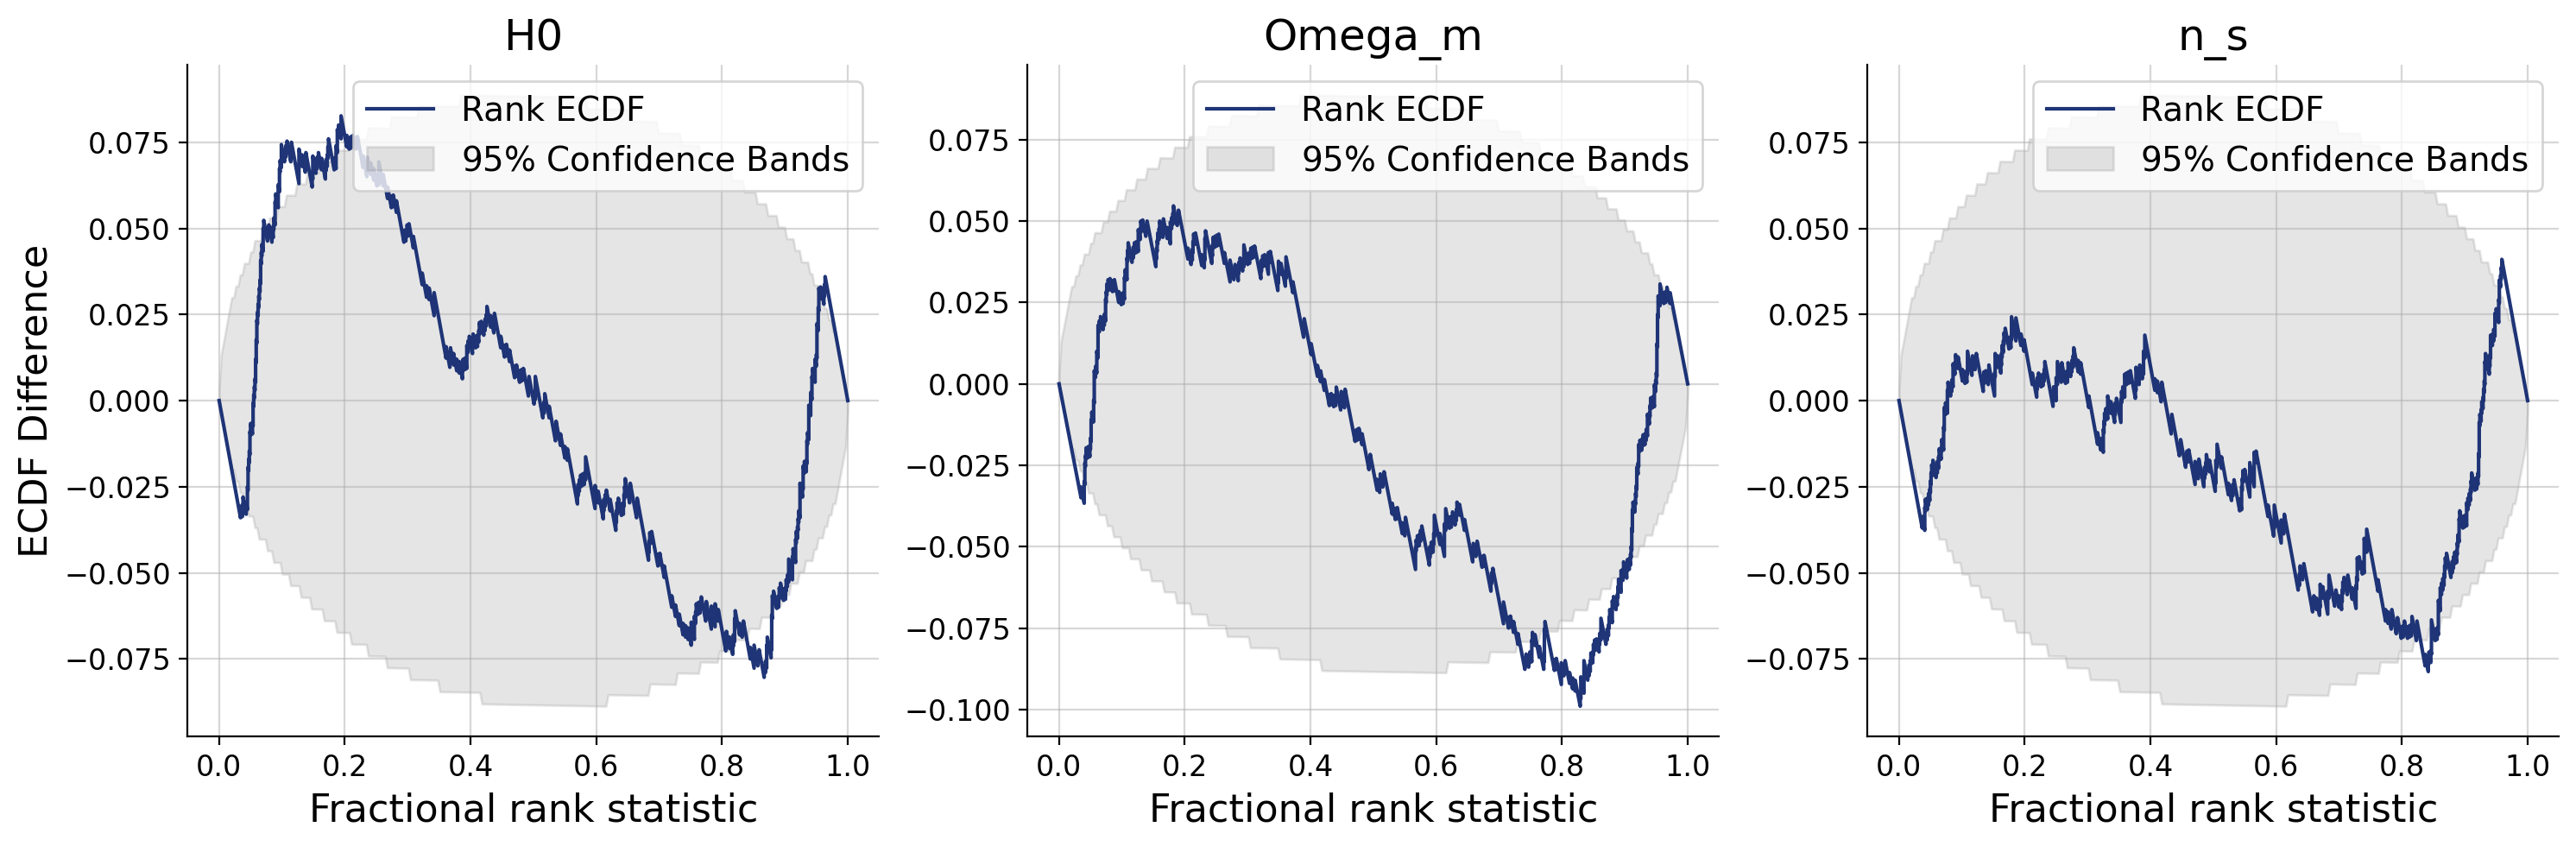

In [262]:
f = bf.diagnostics.plots.calibration_ecdf(samples, test_data, difference=True)

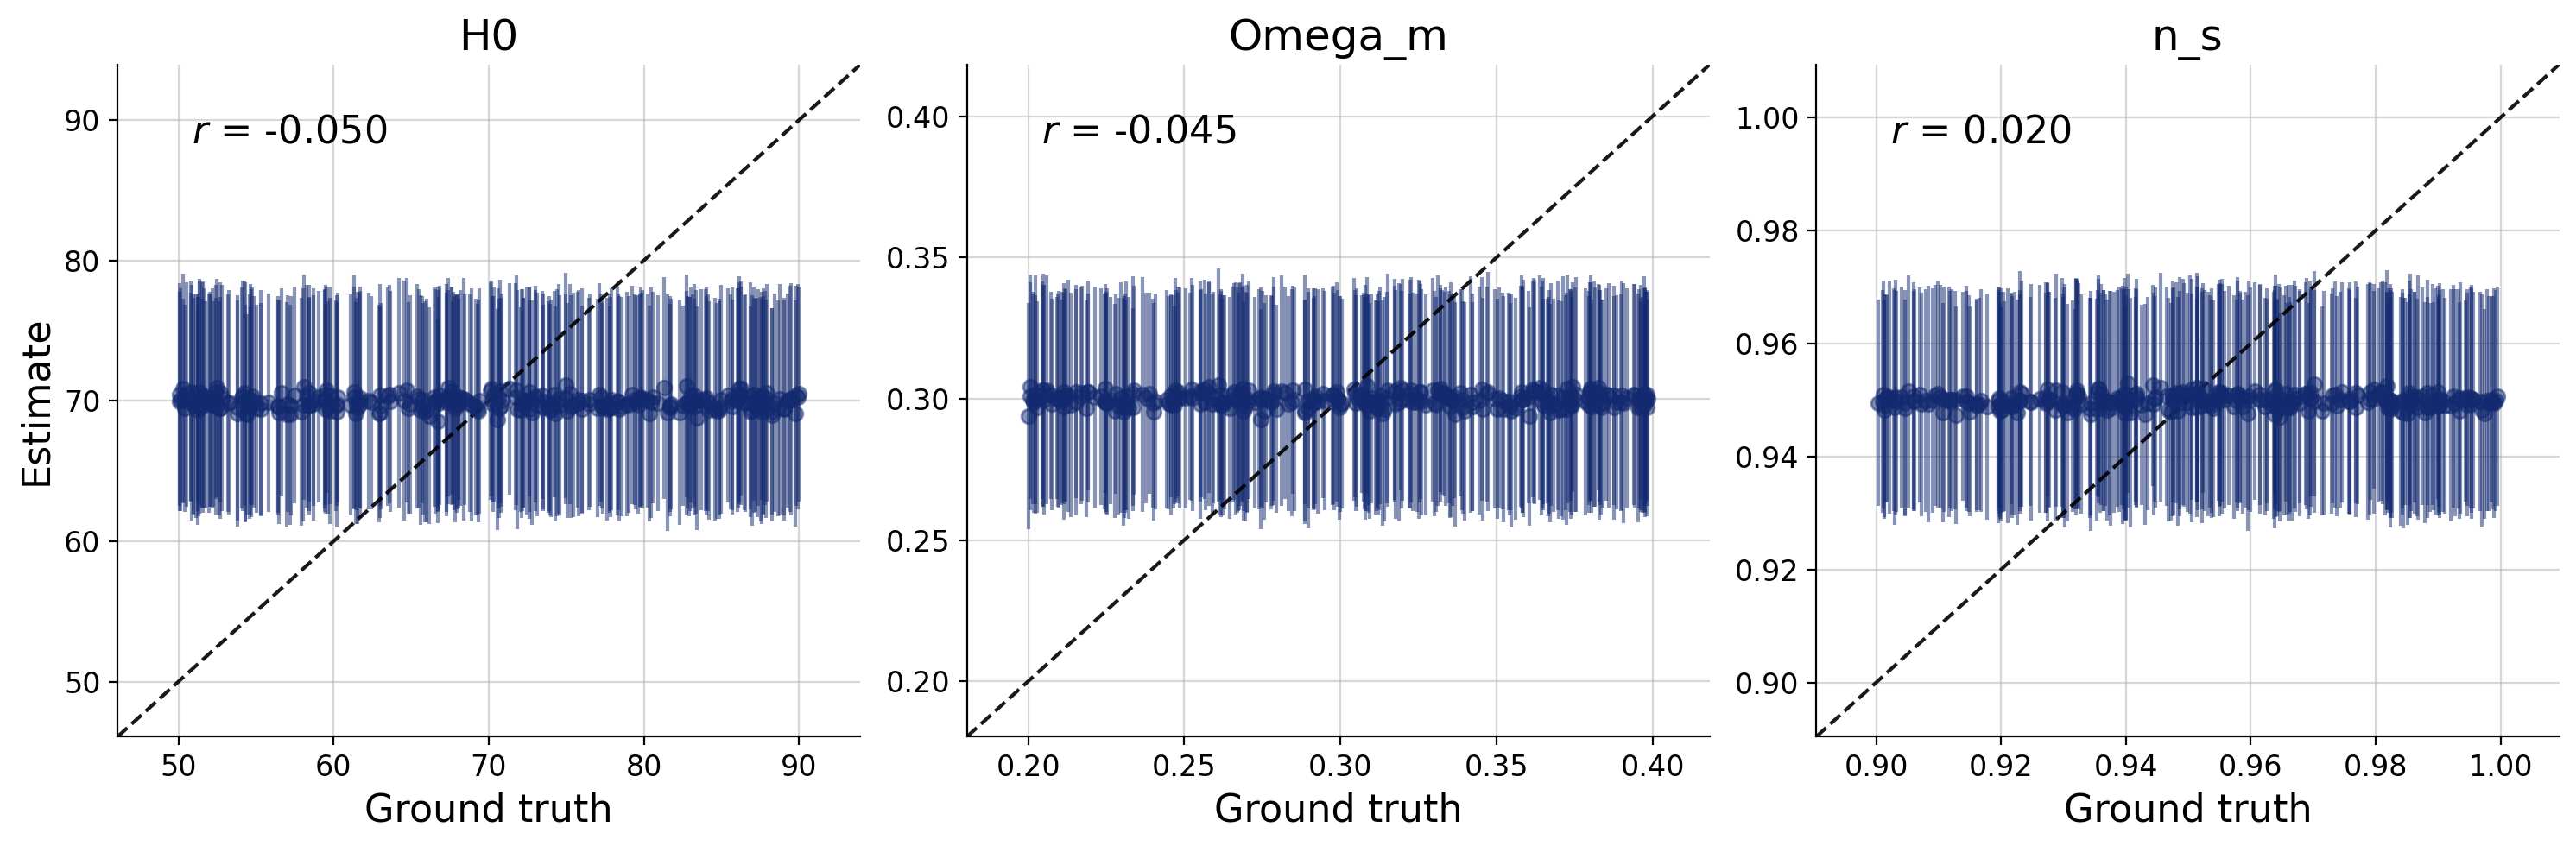

In [263]:
f = bf.diagnostics.plots.recovery(samples, test_data)

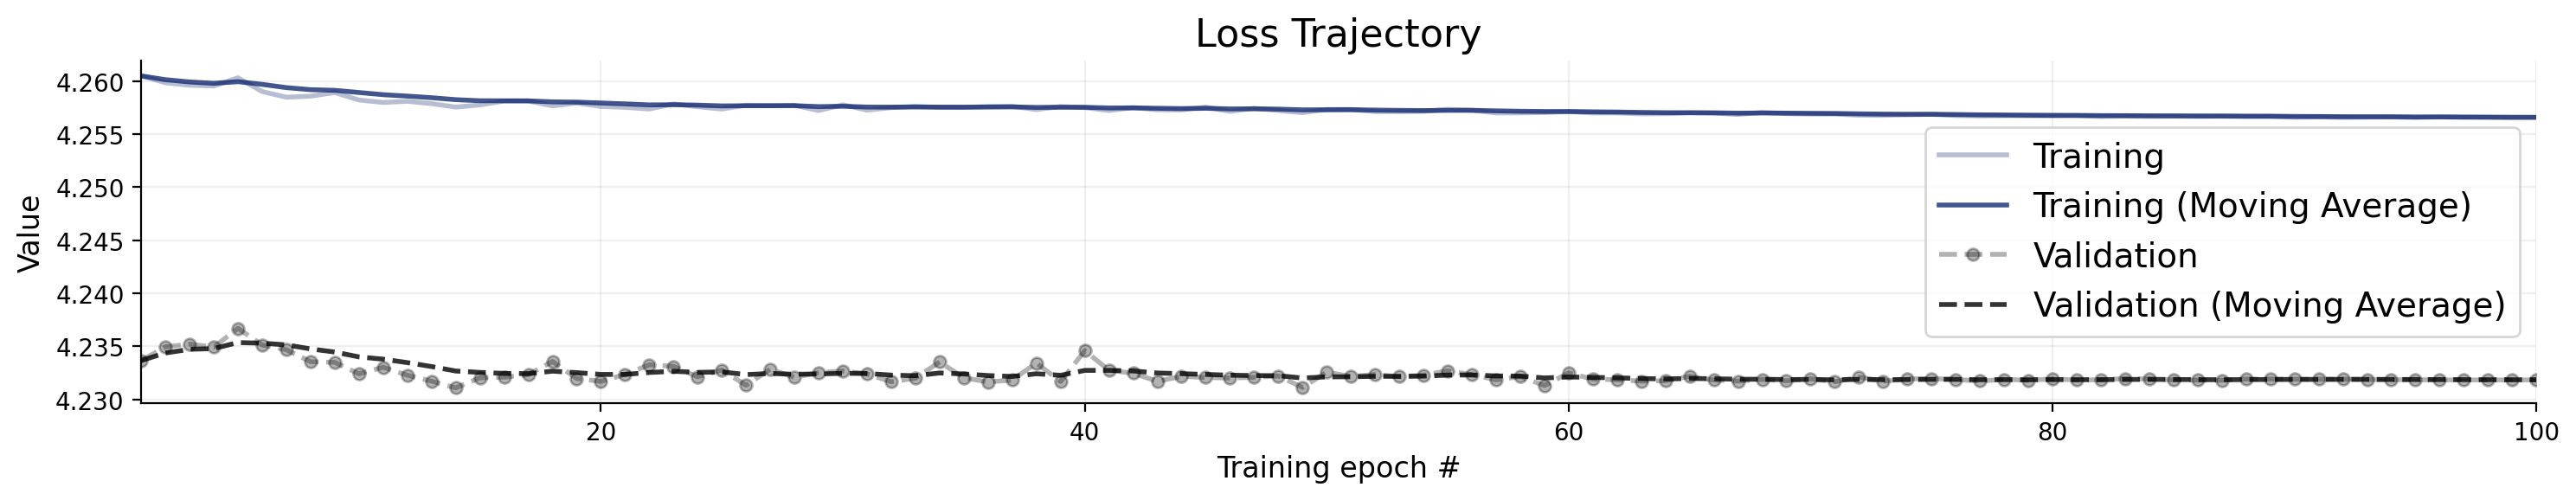

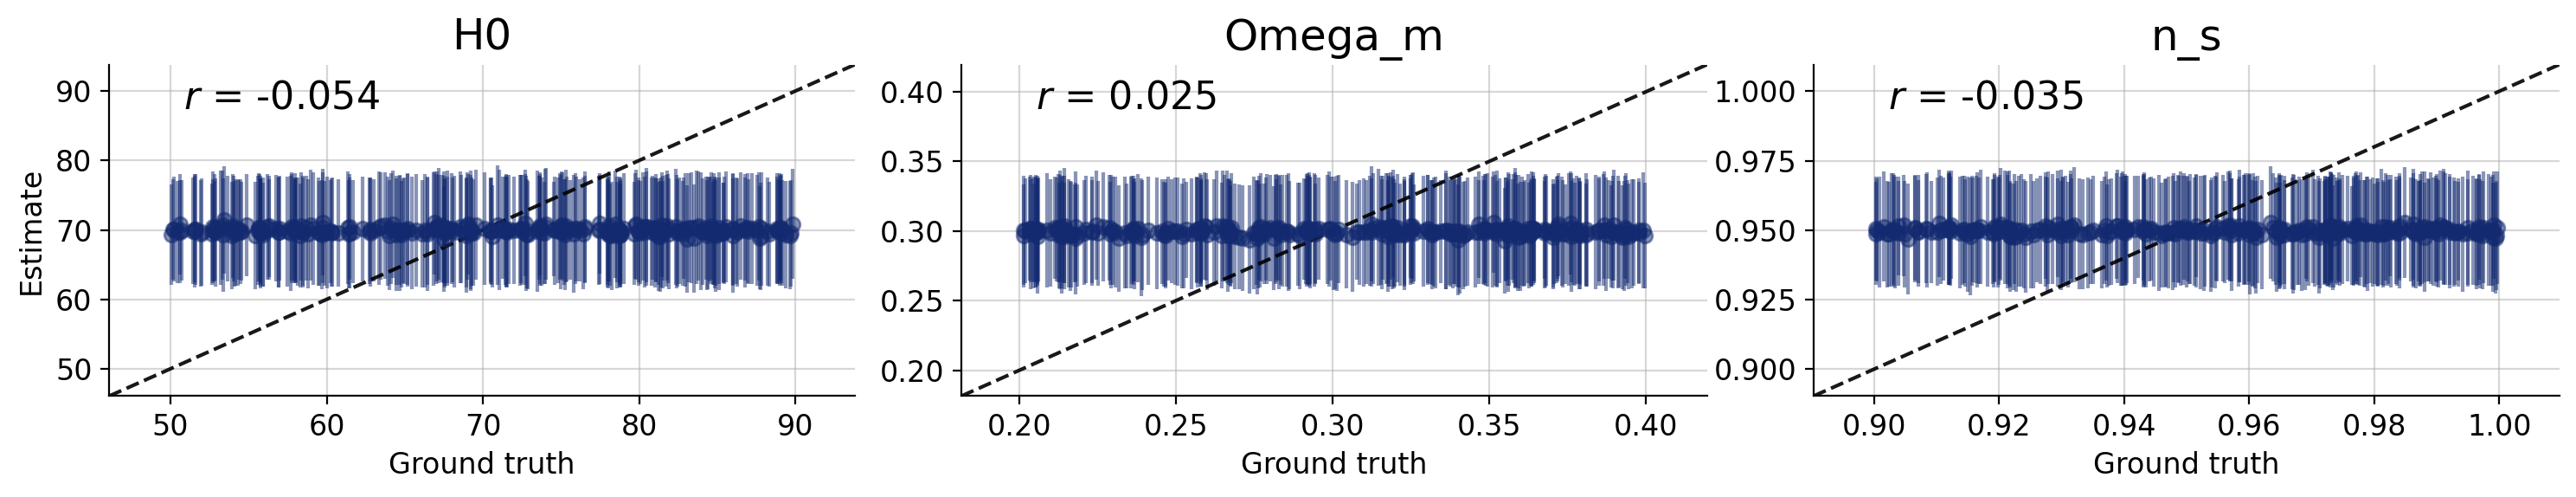

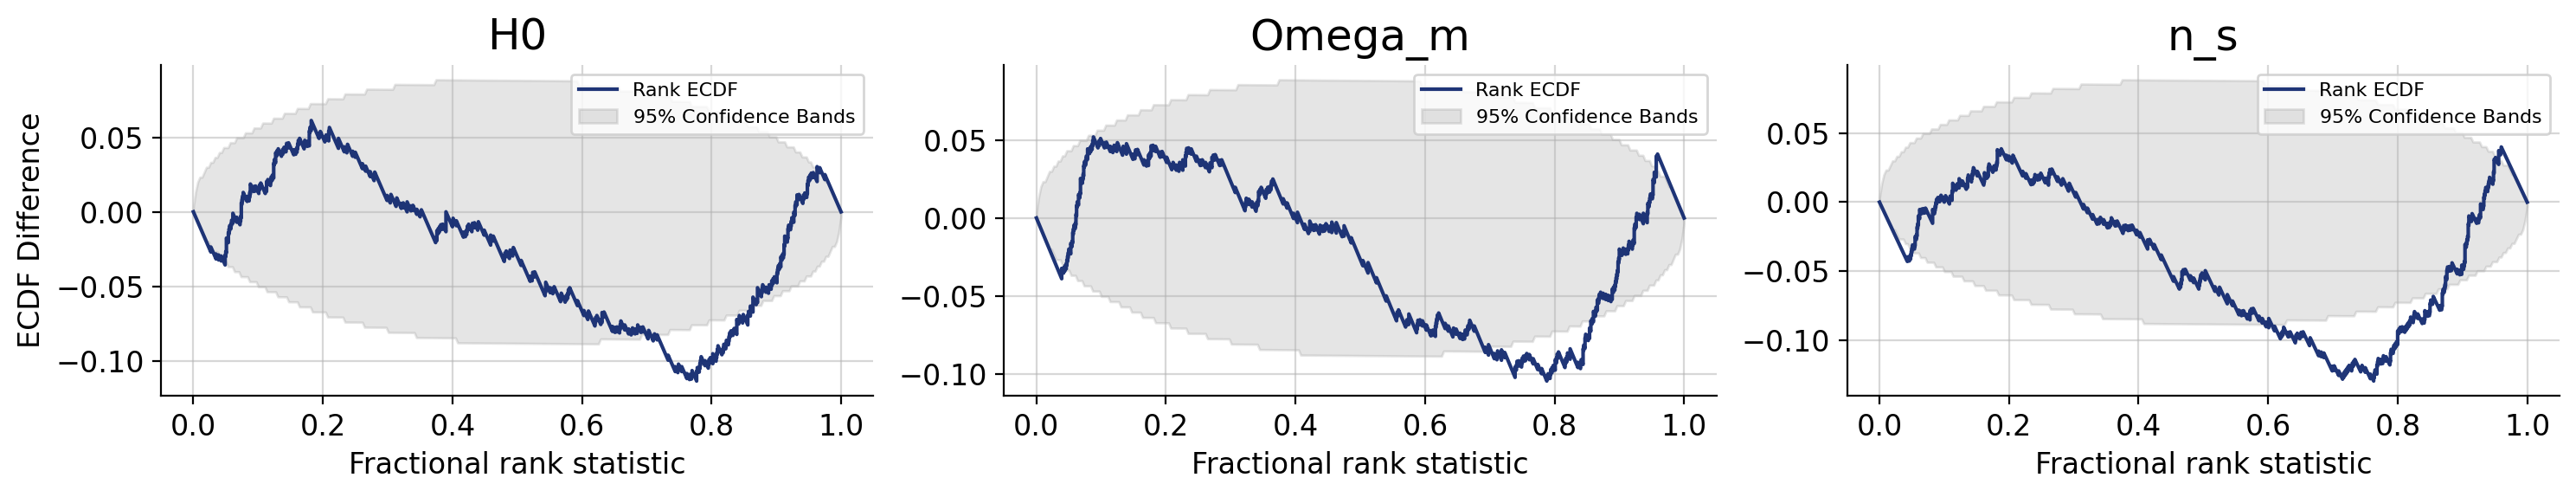

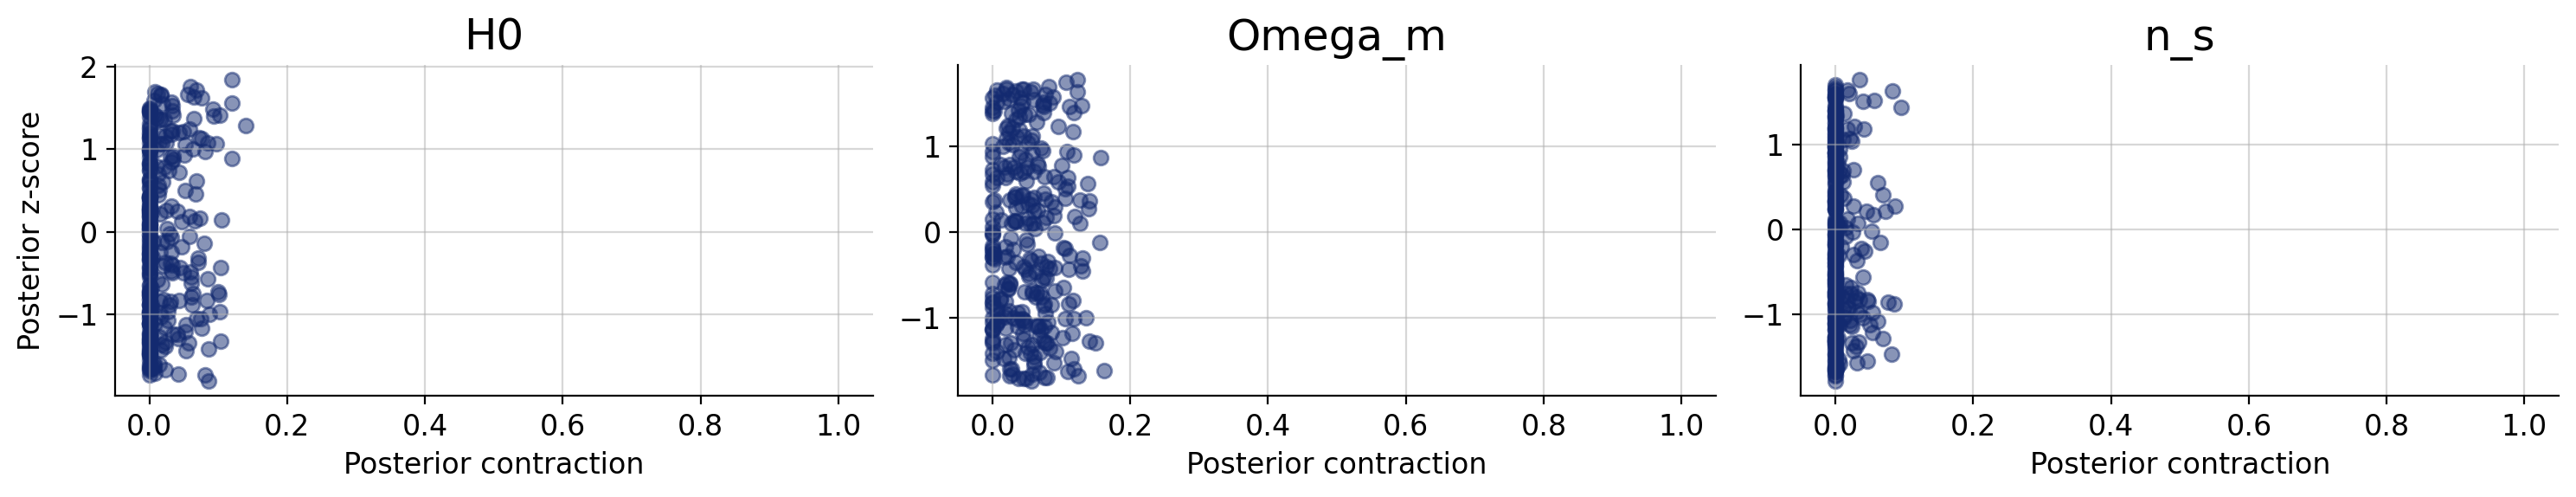

In [264]:
figures = workflow.plot_default_diagnostics(
    test_data=300,
    loss_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    recovery_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    calibration_ecdf_kwargs={"figsize": (15, 3), "legend_fontsize": 8, "difference": True, "label_fontsize": 12},
    z_score_contraction_kwargs={"figsize": (15, 3), "label_fontsize": 12}    
)

# 2) Inference with Spline coupling

In [305]:
inference_network_spline = bf.networks.CouplingFlow(transform="spline")

In [306]:
workflow_spline = bf.BasicWorkflow(
     inference_network=inference_network_spline,
     summary_network=summary_network,
     adapter=adapter,
     simulator=simulator
)

In [307]:
history_spline = workflow_spline.fit_offline(
    data = training_data,
    epochs=100,
    num_batches_per_epoch=200,
    batch_size=128,
    validation_data = validation_data
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 92s 388ms/step - loss: 3.9959 - val_loss: 3.8587
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 22s 276ms/step - loss: 3.8458 - val_loss: 3.8382
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 21s 271ms/step - loss: 3.8346 - val_loss: 3.8899
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 22s 279ms/step - loss: 3.8383 - val_loss: 3.8431
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 21s 267ms/step - loss: 3.8243 - val_loss: 3.8411
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 25s 321ms/step - loss: 3.8155 - val_loss: 3.8139
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 24s 304ms/step - loss: 3.7956 - val_loss: 3.8228
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 39s 276ms/step - loss: 3.7954 - val_loss: 3.7870
Epoch 9/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 22s 283ms/step - loss: 3.7813 - val_loss: 3.8117
Epoch 10/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 21s 270ms/step - loss: 3.7817 - val_loss: 3.8179
Epoch 11/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 22s 276ms/step - loss: 3.7821 - val_loss: 3.8102
Epoch 12/100
79/79 ━━━━━━━━━━━

In [308]:
samples_spline = workflow_spline.sample(conditions=test_data, num_samples=num_samples)

In [321]:
samples_spline["H0"][1]

array([[65.52411 ],
       [63.98054 ],
       [68.82376 ],
       [74.48625 ],
       [74.14616 ],
       [63.181313],
       [66.42784 ],
       [89.36602 ],
       [89.20805 ],
       [81.47378 ],
       [63.671463],
       [67.77562 ],
       [55.760868],
       [55.568253],
       [80.929474],
       [58.905777],
       [80.5767  ],
       [81.954056],
       [53.07041 ],
       [72.29017 ],
       [75.09459 ],
       [58.323578],
       [83.166214],
       [79.52926 ],
       [80.06862 ],
       [58.239685],
       [87.2823  ],
       [61.63775 ],
       [77.48374 ],
       [63.206562],
       [71.60913 ],
       [72.34764 ],
       [81.14107 ],
       [65.179146],
       [51.54464 ],
       [69.853226],
       [86.715355],
       [85.229004],
       [65.38004 ],
       [55.24179 ],
       [88.07335 ],
       [79.419464],
       [80.26939 ],
       [54.618614],
       [52.430763],
       [87.02428 ],
       [72.39335 ],
       [80.560486],
       [80.27053 ],
       [78.77388 ],


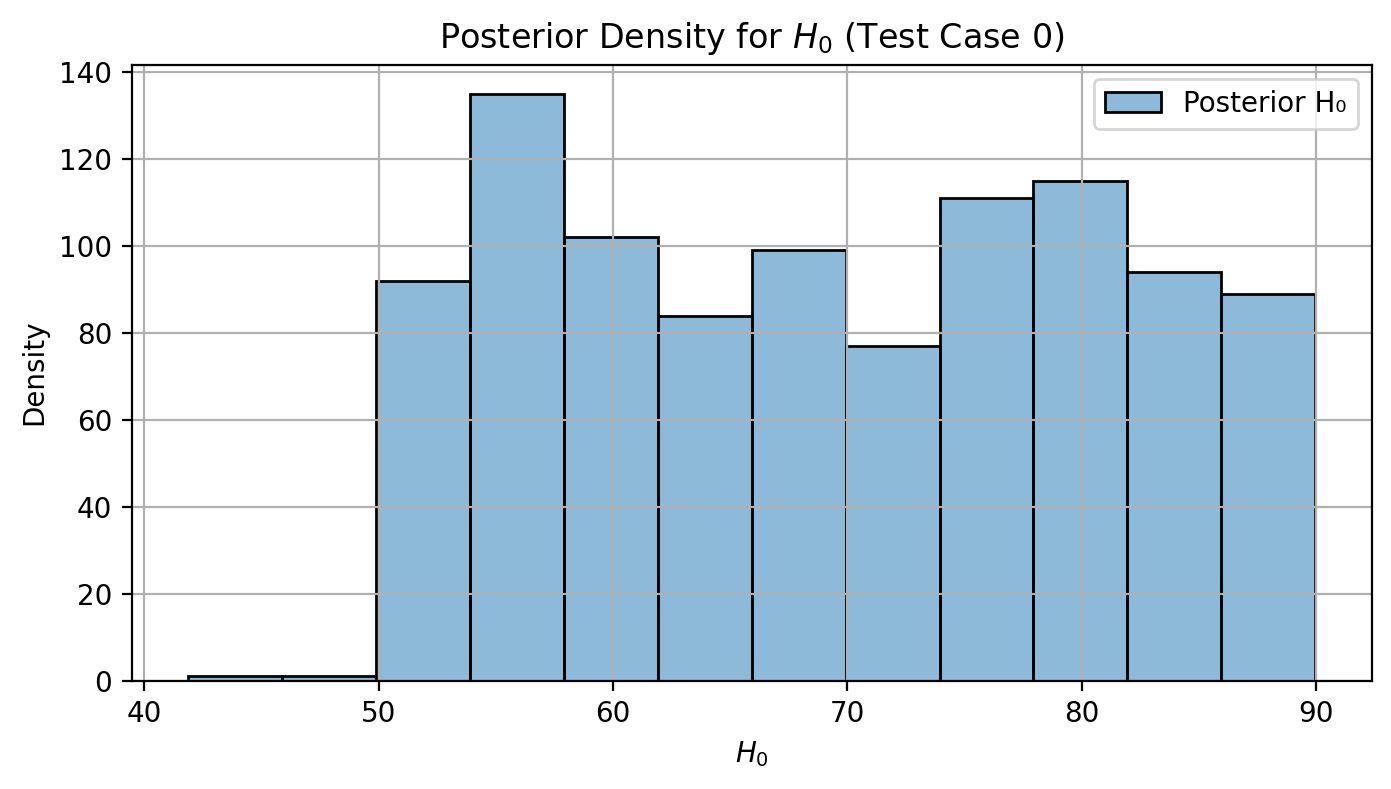

In [334]:
import matplotlib.pyplot as plt
import seaborn as sns




plt.figure(figsize=(8, 4))
sns.histplot(samples_spline["H0"][-1], fill=True, color="skyblue", label="Posterior H₀")
#sns.kdeplot(samples_spline["Omega_m"][1], fill=True, color="skyblue", label="Posterior H₀")
#sns.kdeplot(samples_spline["n_s"][1], fill=True, color="skyblue", label="Posterior H₀")
plt.title("Posterior Density for $H_0$ (Test Case 0)")
plt.xlabel("$H_0$")
plt.ylabel("Density")
plt.grid(True)
plt.legend()
plt.show()


In [332]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select test sample index (e.g., last one)
i = -1

# Extract posterior samples for H0, Omega_m, n_s
samples_h0 = samples_spline[i, :, 0]
samples_omega_m = samples_spline[i, :, 1]
samples_ns = samples_spline[i, :, 2]

plt.figure(figsize=(12, 4))

# Plot H0
plt.subplot(1, 3, 1)
sns.histplot(samples_h0, kde=True, stat='density', color="skyblue", edgecolor='black')
plt.title("Posterior of $H_0$")
plt.xlabel("$H_0$")
plt.ylabel("Density")

# Plot Omega_m
plt.subplot(1, 3, 2)
sns.histplot(samples_omega_m, kde=True, stat='density', color="lightgreen", edgecolor='black')
plt.title("Posterior of $\\Omega_m$")
plt.xlabel("$\\Omega_m$")

# Plot n_s
plt.subplot(1, 3, 3)
sns.histplot(samples_ns, kde=True, stat='density', color="salmon", edgecolor='black')
plt.title("Posterior of $n_s$")
plt.xlabel("$n_s$")

plt.tight_layout()
plt.show()


TypeError: unhashable type: 'slice'

In [311]:
#str(test_data)

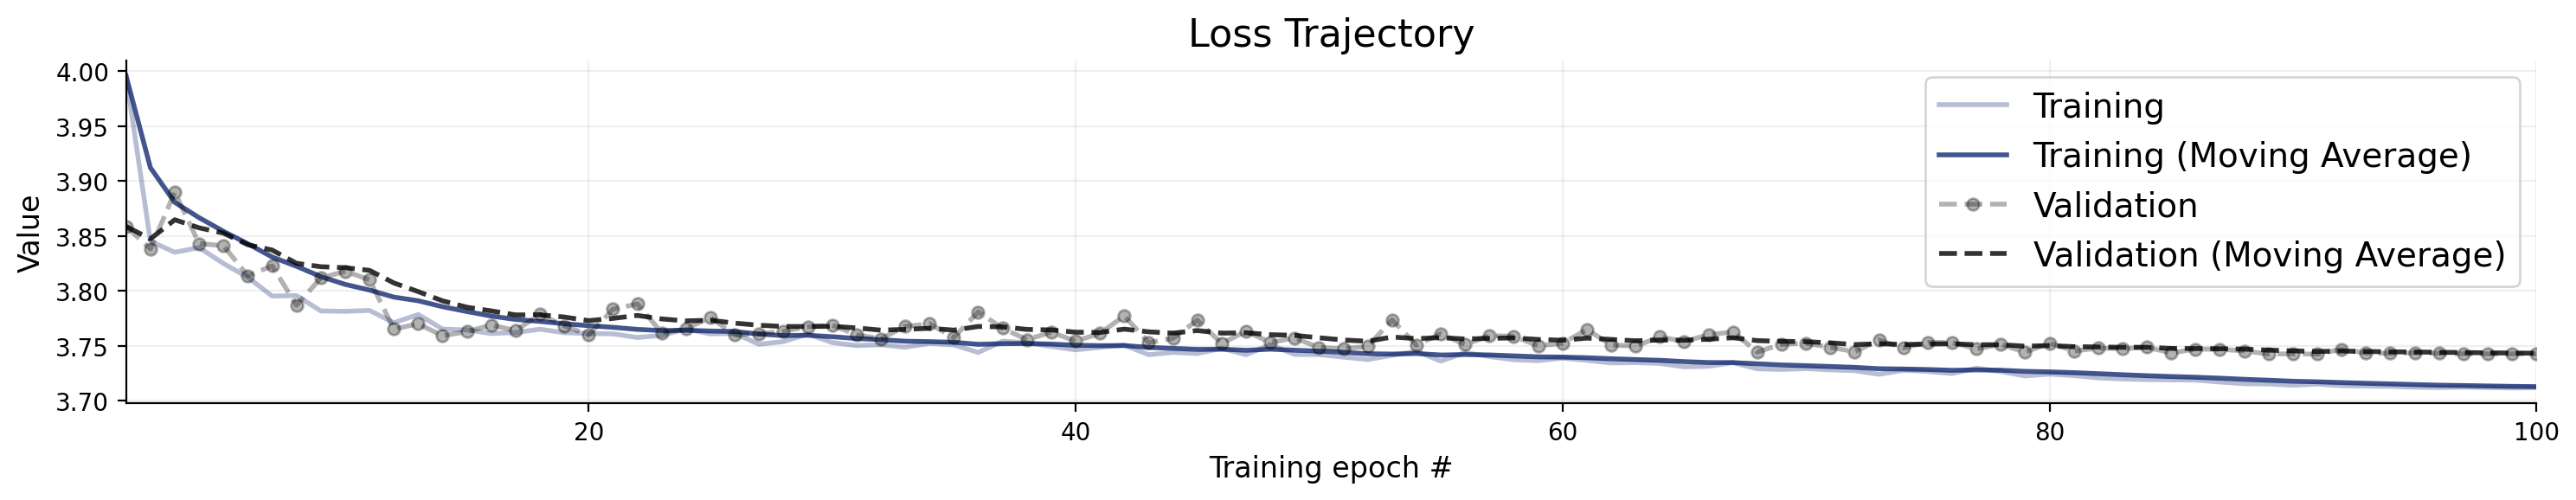

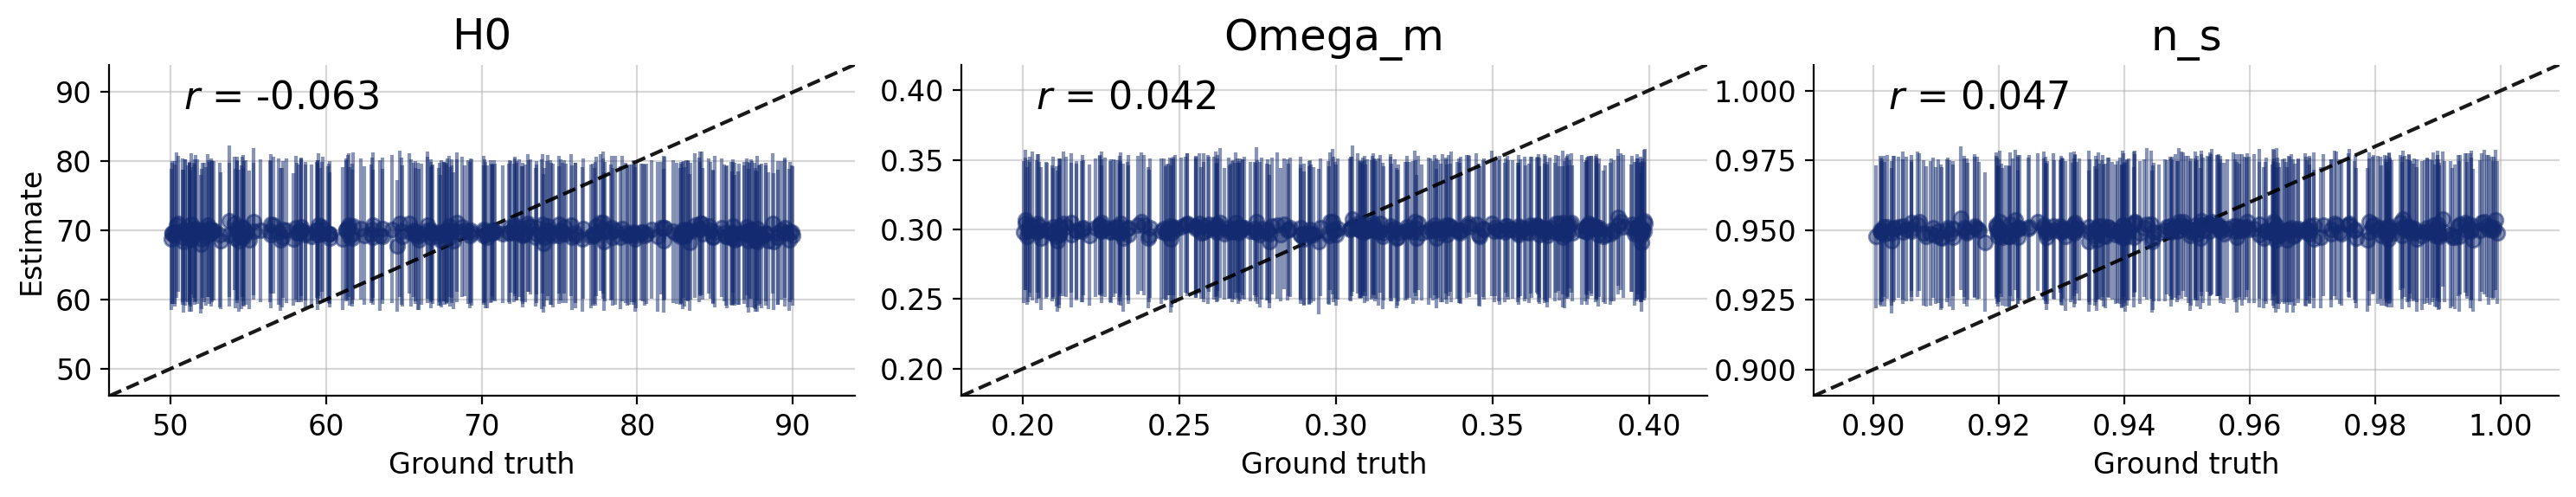

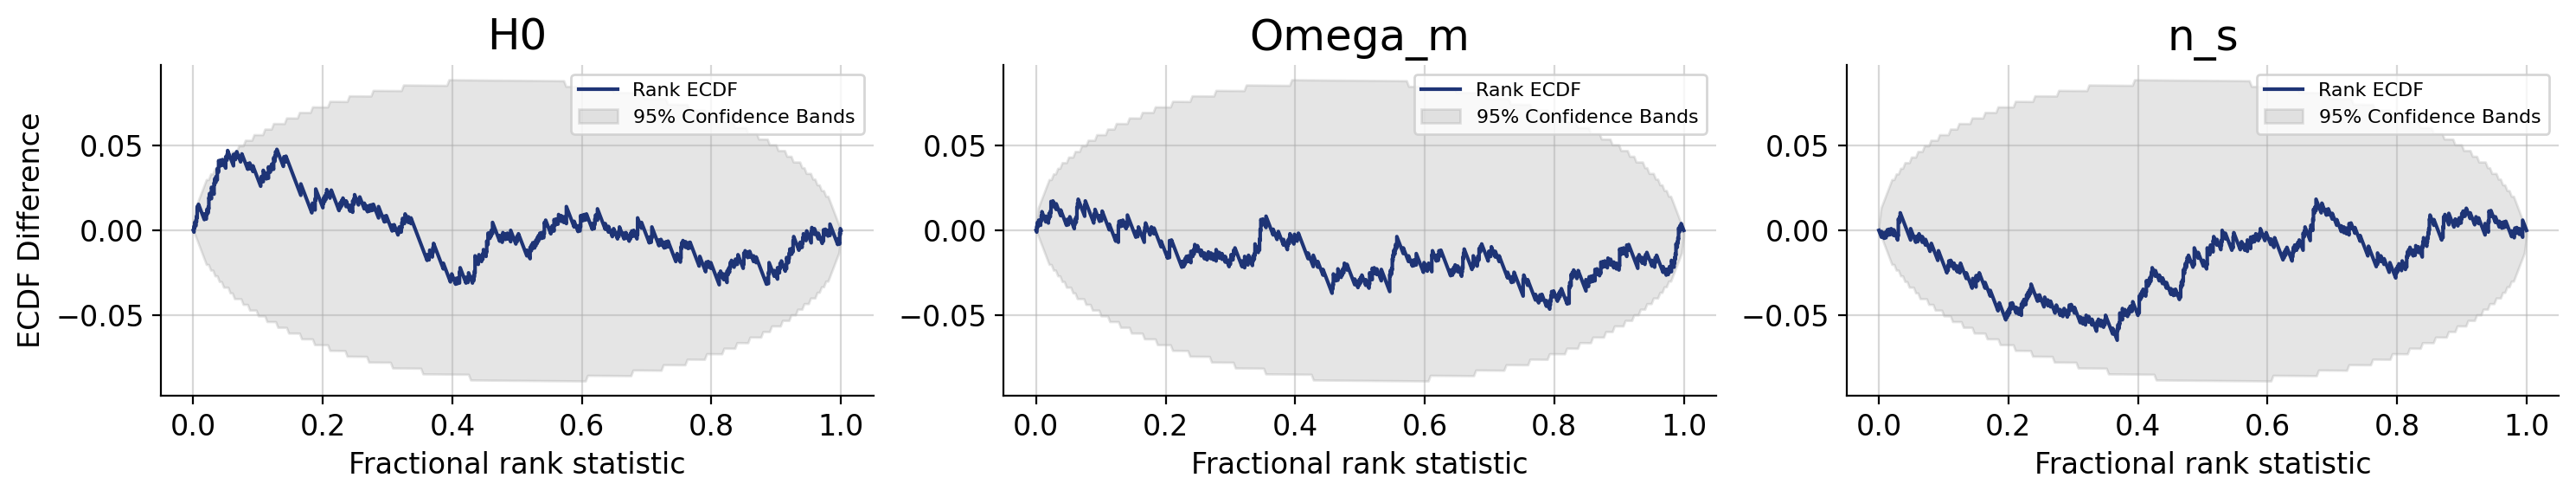

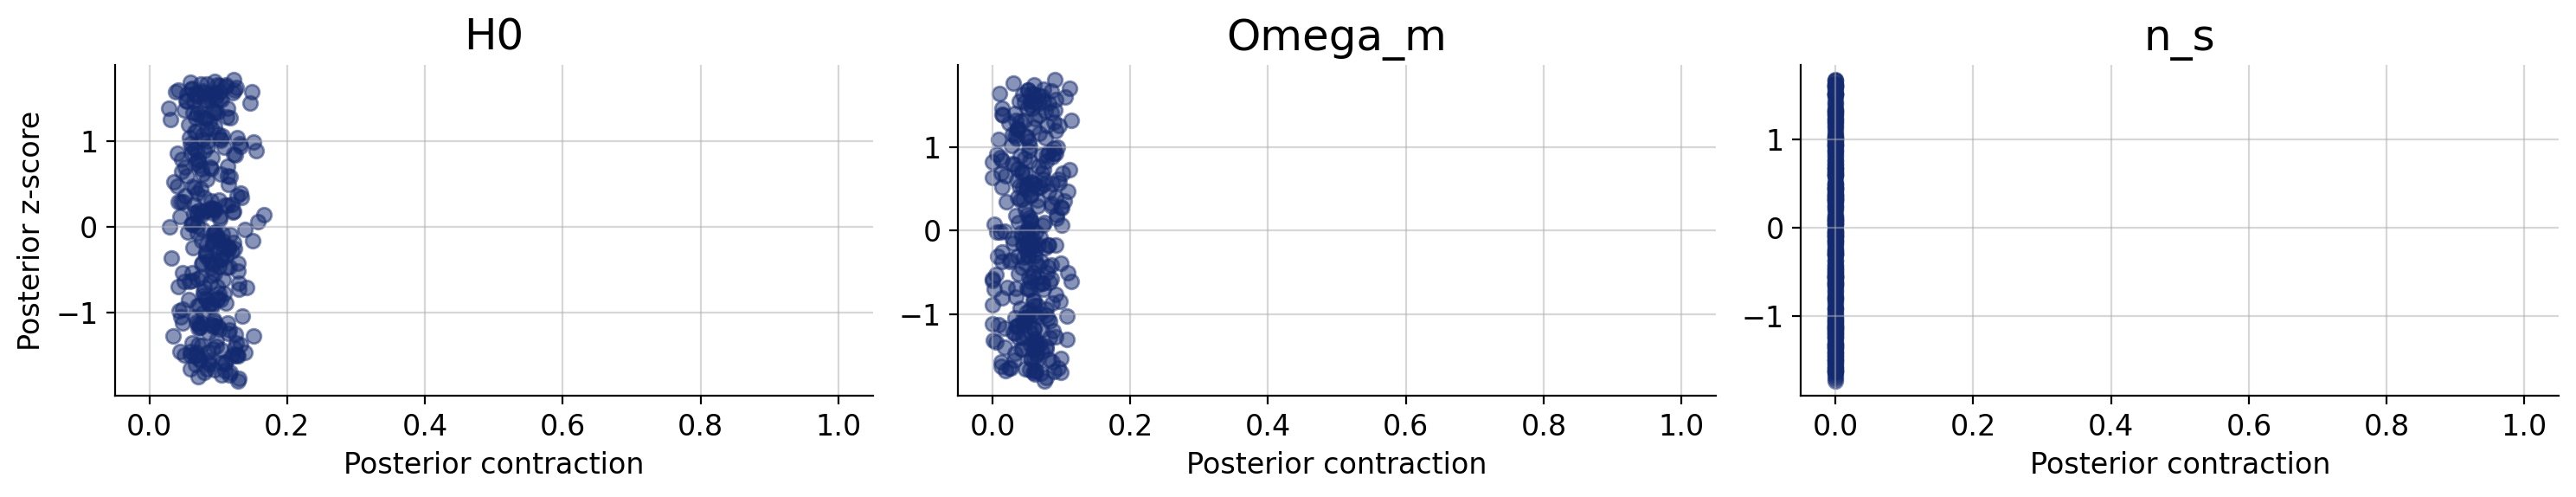

In [312]:
figures_spline = workflow_spline.plot_default_diagnostics(
    test_data=test_data,
    loss_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    recovery_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    calibration_ecdf_kwargs={"figsize": (15, 3), "legend_fontsize": 8, "difference": True, "label_fontsize": 12},
    z_score_contraction_kwargs={"figsize": (15, 3), "label_fontsize": 12}    
)

# 3) Flow matching 

In [313]:
inference_network_flow = bf.networks.FlowMatching()

In [ ]:
workflow_flow = bf.BasicWorkflow(
     inference_network=inference_network_flow,
     summary_network=summary_network,
     adapter=adapter,
     simulator=simulator
)

In [ ]:
history_spline = workflow_spline.fit_offline(
    data = training_data,
    epochs=100,
    num_batches_per_epoch=200,
    batch_size=128,
    validation_data = validation_data
)